In [1]:
import pandas as pd
import numpy as np
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

In [2]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

2024-08-06 10:30:34.538620: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 10:30:34.567108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
path='/home/hwchoi/001.project/data/T_PATIENTS_DAILY_WHOLE_0731.csv'
df_raw=pd.read_csv(path)
df_raw.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,...,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,...,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


###  MODELING

#### 1. create_date sorting 적용 케이스

In [6]:
# create_date에 대한 sorting 적용
df_raw['create_date'] = pd.to_datetime(df_raw['create_date'])
df_raw.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df_raw = df_raw.fillna(0)

In [7]:
features=['weekend_yn', 'sido_cd', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
       'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
       'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2',
       'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'
print(len(features))

49


In [8]:
# 데이터 스케일링
scaler = StandardScaler()
df_raw[features]=scaler.fit_transform(df_raw[features])

# 입력 시퀀스 준비 함수
def create_sequences(data, features, target, sequence_length):
    X = []
    y = []
    dates = []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:i+sequence_length].values)
        y.append(data[target].iloc[i+sequence_length])
        dates.append(data['create_date'].iloc[i+sequence_length])
    return np.array(X), np.array(y), np.array(dates)

In [9]:
sequence_length = 15
X, y, dates = create_sequences(df_raw, features, target, sequence_length)

# 학습 데이터와 테스트 데이터로 분할
X_train_seq, X_test_seq, y_train_seq, y_test_seq, dates_train, dates_test = train_test_split(X, y, dates, test_size=0.2, random_state=11, shuffle=False)

print("X_train shape:", X_train_seq.shape)
print("X_test shape:", X_test_seq.shape)
print("y_train shape:", y_train_seq.shape)
print("y_test shape:", y_test_seq.shape)

X_train shape: (20796, 15, 49)
X_test shape: (5199, 15, 49)
y_train shape: (20796,)
y_test shape: (5199,)


#### 1-1. RNN Modeling

In [10]:
# RNN 모델
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, len(features))))
rnn_model.add(Dense(1))
# 모델 compile
rnn_model.compile(optimizer='adam', loss='mse')

# 학습 모델
rnn_history = rnn_model.fit(X_train_seq, y_train_seq, epochs=50, validation_data=(X_test_seq, y_test_seq))

# 모델 평가
rnn_loss = rnn_model.evaluate(X_test_seq, y_test_seq)

# 예측값 생성
rnn_predictions = rnn_model.predict(X_test_seq)

# 평가지표
rnn_mae = mean_absolute_error(y_test_seq, rnn_predictions)
rnn_mse = mean_squared_error(y_test_seq, rnn_predictions)
rnn_r2 = r2_score(y_test_seq, rnn_predictions)

print('RNN Test MAE:', rnn_mae)
print('RNN Test Loss:', rnn_loss)
print('RNN Test MSE:', rnn_mse)
print('RNN Test R^2:', rnn_r2)

Epoch 1/50


/home/hwchoi/anaconda3/envs/kdca/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7551 - val_loss: 3.8791
Epoch 2/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2046 - val_loss: 3.5649
Epoch 3/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4157 - val_loss: 3.5606
Epoch 4/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0328 - val_loss: 3.3378
Epoch 5/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1292 - val_loss: 3.2309
Epoch 6/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5660 - val_loss: 3.3413
Epoch 7/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2555 - val_loss: 3.1354
Epoch 8/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5440 - val_loss: 3.4369
Epoch 9/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8445 - val_loss: 3.5572
Epoch 10/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.0936 - val_loss: 3.7174
Epoch 11/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6199 - val_loss: 3.3307
Epoch 12/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.

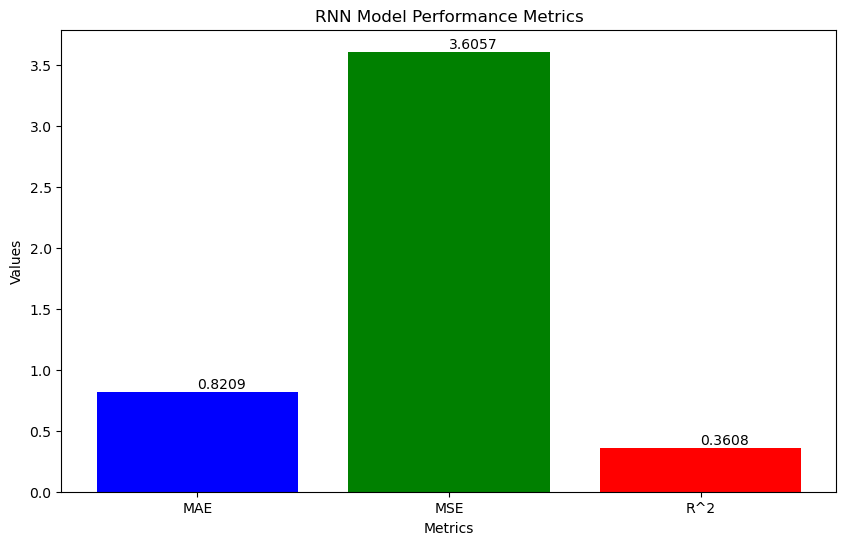

In [11]:
# 성능 평가 지표를 리스트로 정리
model = ['RNN', 'RNN', 'RNN']
metrics = ['MAE', 'MSE', 'R^2']
values = [rnn_mae, rnn_mse, rnn_r2]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RNN Model Performance Metrics')
plt.show()

#### 1-2. LSTM Modeling

In [12]:
# LSTM 모델 빌드
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(features))))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# LSTM 모델 학습
lstm_history = lstm_model.fit(X_train_seq, y_train_seq, epochs=50, validation_data=(X_test_seq, y_test_seq))

# LSTM 모델 평가
lstm_loss = lstm_model.evaluate(X_test_seq, y_test_seq)
print('LSTM Test Loss:', lstm_loss)

# 예측값 생성
lstm_predictions = lstm_model.predict(X_test_seq)

# 추가 평가 지표
lstm_mae = mean_absolute_error(y_test_seq, lstm_predictions)
lstm_mse = mean_squared_error(y_test_seq, lstm_predictions)
lstm_r2 = r2_score(y_test_seq, lstm_predictions)

print('RNN Test MAE:', lstm_mae)
print('RNN Test MSE:', lstm_mse)
print('RNN Test R^2:', lstm_r2)

Epoch 1/50


/home/hwchoi/anaconda3/envs/kdca/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.0126 - val_loss: 3.6672
Epoch 2/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.6037 - val_loss: 3.6231
Epoch 3/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.5083 - val_loss: 3.8180
Epoch 4/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.5002 - val_loss: 3.4368
Epoch 5/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.6434 - val_loss: 3.3197
Epoch 6/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.9427 - val_loss: 3.1436
Epoch 7/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.8623 - val_loss: 3.3023
Epoch 8/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.9860 - val_loss: 3.3253
Epoch 9/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.7425 - val_loss: 3.1941
Epoch 10/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.6318 - val_loss: 3.1516
Epoch 11/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.4579 - val_loss: 2.9909
Epoch 12/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.

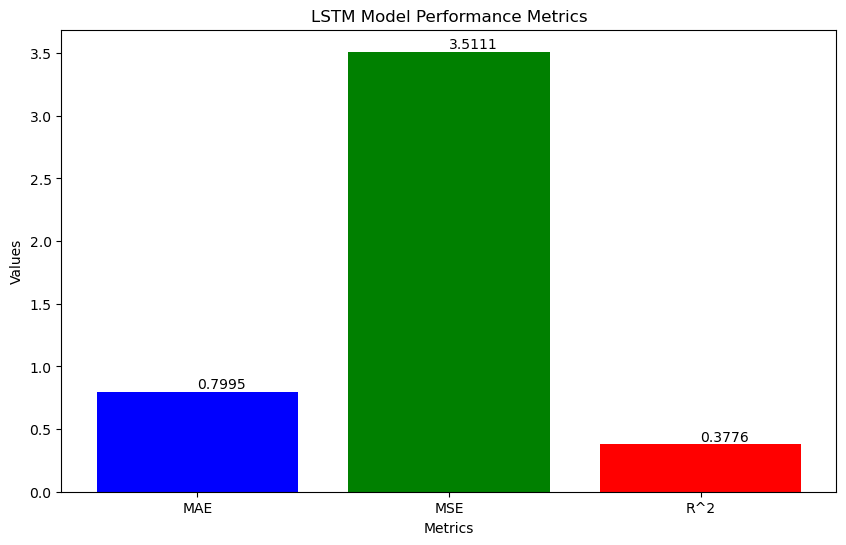

In [13]:
# 성능 평가 지표를 리스트로 정리
model = ['LSTM', 'LSTM', 'LSTM']
metrics = ['MAE', 'MSE', 'R^2']
values = [lstm_mae, lstm_mse, lstm_r2]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('LSTM Model Performance Metrics')
plt.show()

### RandomForest, XGBoost 데이터 셋 재정리

In [14]:
path='/home/hwchoi/001.project/data/T_PATIENTS_DAILY_WHOLE_0731.csv'
df=pd.read_csv(path)
df.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,...,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,...,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


In [15]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [17]:
features=['weekend_yn', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm', 'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man', 'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'
print(len(features))

48


In [18]:
# 데이터 스케일링
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=11, shuffle=True)

#### 1-3. RandomForest Modeling

In [19]:
# RF 모델 빌드
rf_model = RandomForestRegressor(n_estimators=100, random_state=11)
rf_model.fit(X_train, y_train)

# RF 모델
rf_predictions = rf_model.predict(X_test)

# 추가 평가지표 계산
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print('RandomForest Test MAE:', rf_mae)
print('RandomForest Test MSE:', rf_mse)
print('RandomForest Test R^2:', rf_r2)

RandomForest Test MAE: 0.5353940792003076
RandomForest Test MSE: 1.532480123029604
RandomForest Test R^2: 0.7473551937048468


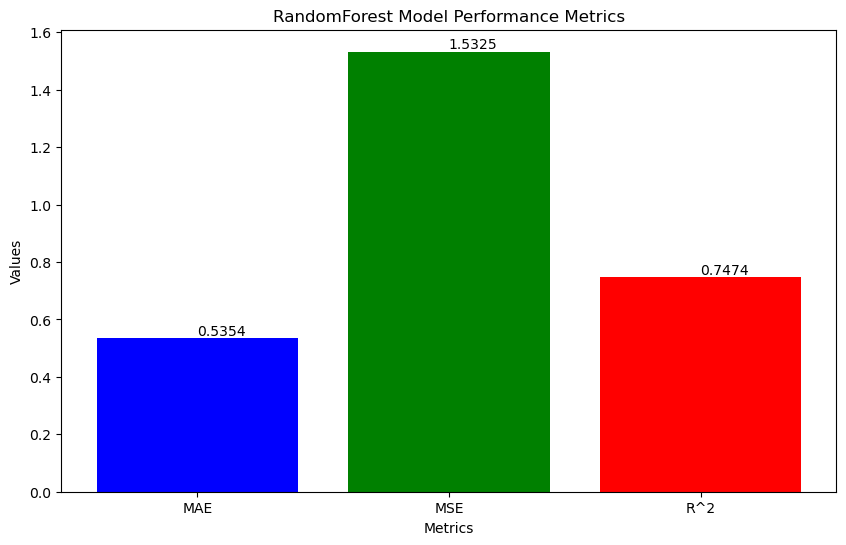

In [20]:
# 성능 평가 지표를 리스트로 정리
model = ['RandomForest', 'RandomForest', 'RandomForest']
metrics = ['MAE', 'MSE', 'R^2']
values = [rf_mae, rf_mse, rf_r2]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RandomForest Model Performance Metrics')
plt.show()

#### 1-4. XGBoostRegressor Modeling

In [21]:
# XGBoost 모델 빌드
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=11)
xgb_model.fit(X_train, y_train)

# XGBoost 모델
xgb_predictions = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_predictions)

# 추가 평가지표 계산
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print('XGBoost Test MAE:', xgb_mae)
print('XGBoost Test MSE:', xgb_mse)
print('XGBoost Test R^2:', xgb_r2)

XGBoost Test MAE: 0.5060832079654636
XGBoost Test MSE: 1.4661960536369973
XGBoost Test R^2: 0.7582827806472778


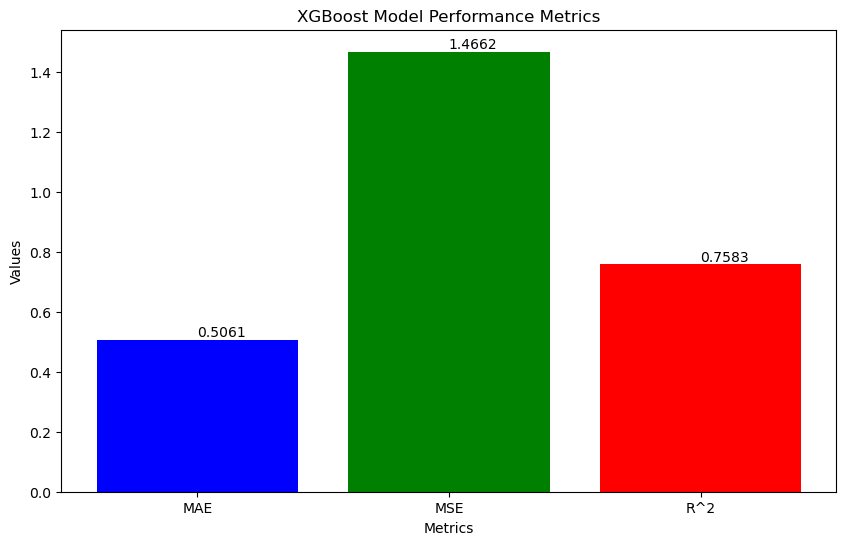

In [22]:
# 성능 평가 지표를 리스트로 정리
model = ['XGBoost', 'XGBoost', 'XGBoost']
metrics = ['MAE', 'MSE', 'R^2']
values = [xgb_mae, xgb_mse, xgb_r2]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('XGBoost Model Performance Metrics')
plt.show()

#### 1-5. 시각화로 나타내기

#### 실제값과 모델별 예측값 확인하기

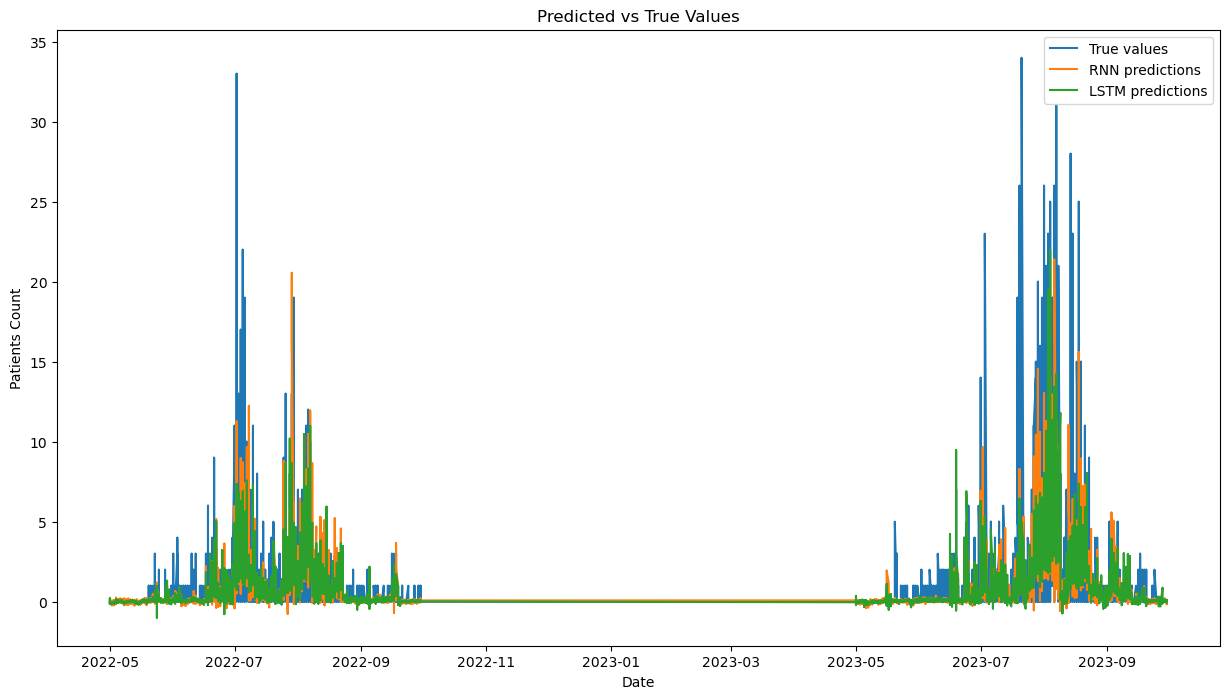

In [23]:
# 결과 시각화
plt.figure(figsize=(15,8))
plt.plot(dates_test, y_test_seq, label='True values')
plt.plot(dates_test, rnn_predictions, label='RNN predictions')
plt.plot(dates_test, lstm_predictions, label='LSTM predictions')
plt.xlabel('Date')
plt.ylabel('Patients Count')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()

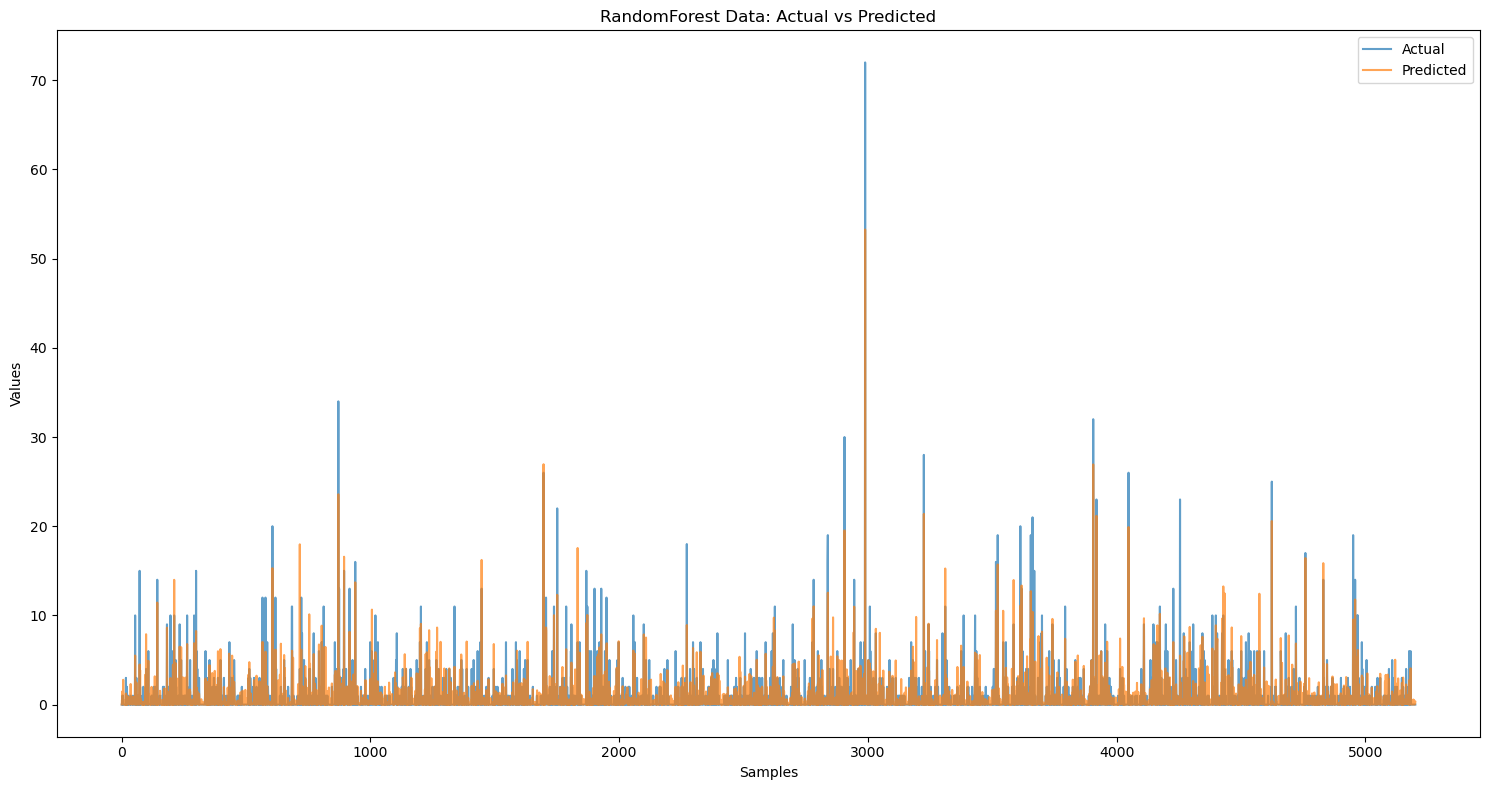

In [24]:
# 실제값과 예측값을 비교하는 라인차트 시각화
plt.figure(figsize=(10,6))

# Test 데이터에 대한 라인차트
plt.plot(y_test.reset_index(drop=True), label='Actual', alpha=0.7)
plt.plot(rf_predictions, label='Predicted', alpha=0.7)
plt.title('RandomForest Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

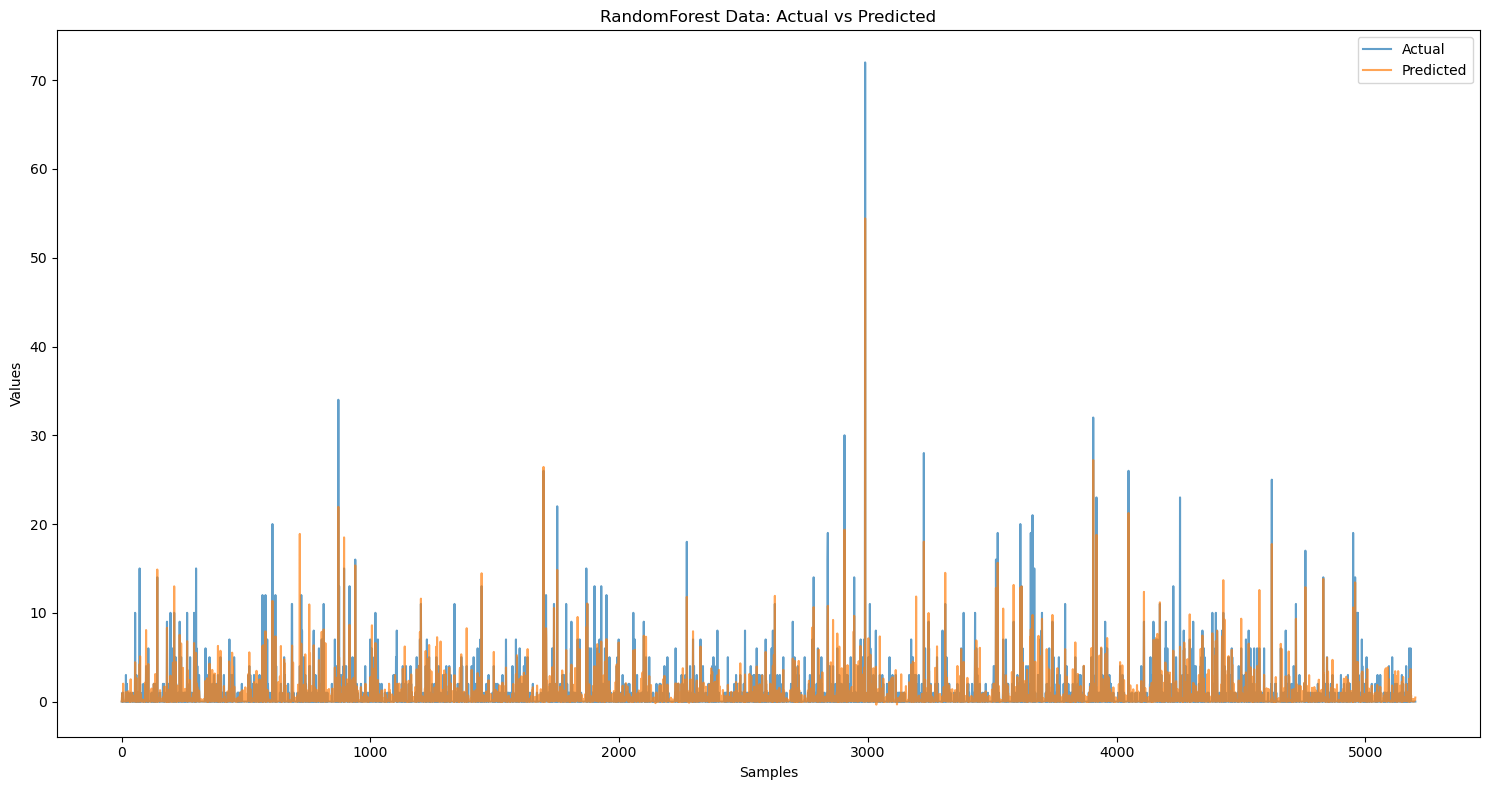

In [25]:
# 실제값과 예측값을 비교하는 라인차트 시각화
plt.figure(figsize=(15,8))

# Test 데이터에 대한 라인차트
plt.plot(y_test.reset_index(drop=True), label='Actual', alpha=0.7)
plt.plot(xgb_predictions, label='Predicted', alpha=0.7)
plt.title('RandomForest Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

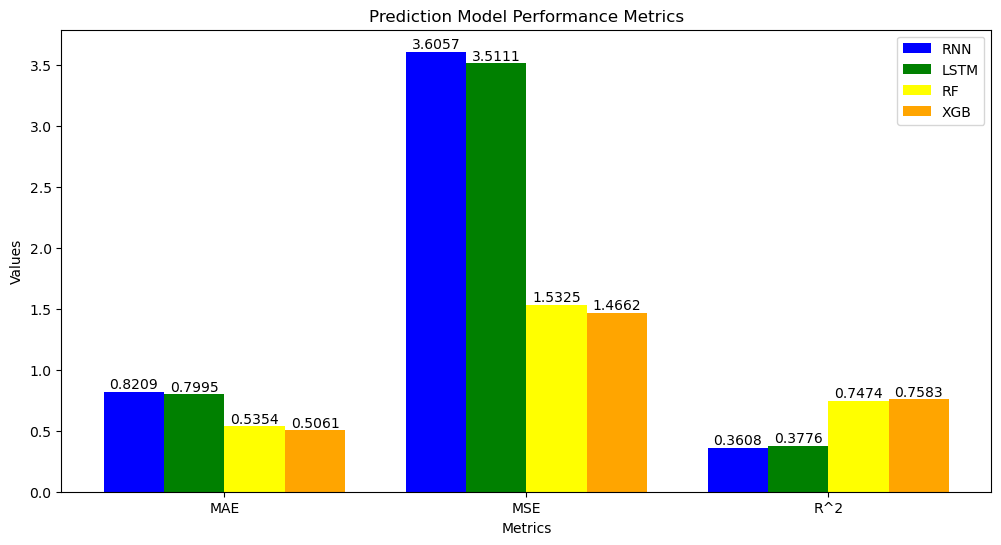

: 

In [26]:
# 성능 평가 지표를 리스트로 정리
metrics = ['MAE', 'MSE', 'R^2']
rnn_values = [rnn_mae, rnn_mse, rnn_r2]
lstm_values = [lstm_mae, lstm_mse, lstm_r2]
rf_values = [rf_mae, rf_mse, rf_r2]
xgb_values = [xgb_mae, xgb_mse, xgb_r2]

# 시각화
x = np.arange(len(metrics))  # 각 지표에 대한 레이블 위치
width = 0.2  # 막대 너비

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5 * width, rnn_values, width, label='RNN', color='blue')
bars2 = ax.bar(x - 0.5 * width, lstm_values, width, label='LSTM', color='green')
bars3 = ax.bar(x + 0.5 * width, rf_values, width, label='RF', color='yellow')
bars4 = ax.bar(x + 1.5 * width, xgb_values, width, label='XGB', color='orange')

# 막대 그래프에 값 표시
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

# 레이블 및 제목 설정
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Prediction Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.savefig('Prediction Model Performance Metrics.png')
plt.show()

### Feature Selection
    - Feature Importance
    - Drop-Column Importance
    - Permutation Importance

#### 1. Feature Importance

In [4]:
path='/home/hwchoi/001.project/data/T_PATIENTS_DAILY_WHOLE_0731.csv'
df=pd.read_csv(path)
df.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,...,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,...,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


In [5]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [6]:
features=['weekend_yn', 'sido_cd', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
       'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
       'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2',
       'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'
print(len(features))

49


In [7]:
# 데이터 스케일링
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=11, shuffle=True)

In [8]:
# RF 모델 빌드
rf_model = RandomForestRegressor(n_estimators=100, random_state=11)
rf_model.fit(X_train, y_train)

# RF 모델
rf_predictions = rf_model.predict(X_test)

# 특성 중요도 계산
feature_importances = rf_model.feature_importances_

# 특성 중요도를 데이터프레임으로 정렬
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

In [9]:
importance_df

,Feature,Importance
7,max_tafeel,0.363602
28,popular_woman,0.118187
27,popular_man,0.108828
23,heatalert_temp,0.054334
8,mean_tafeel,0.038743
24,ta_min_3days,0.025640
22,heatwave_temp,0.015663
19,max_ws,0.015263
20,mean_ws,0.014793
45,ta_mean_six_pm1,0.012475


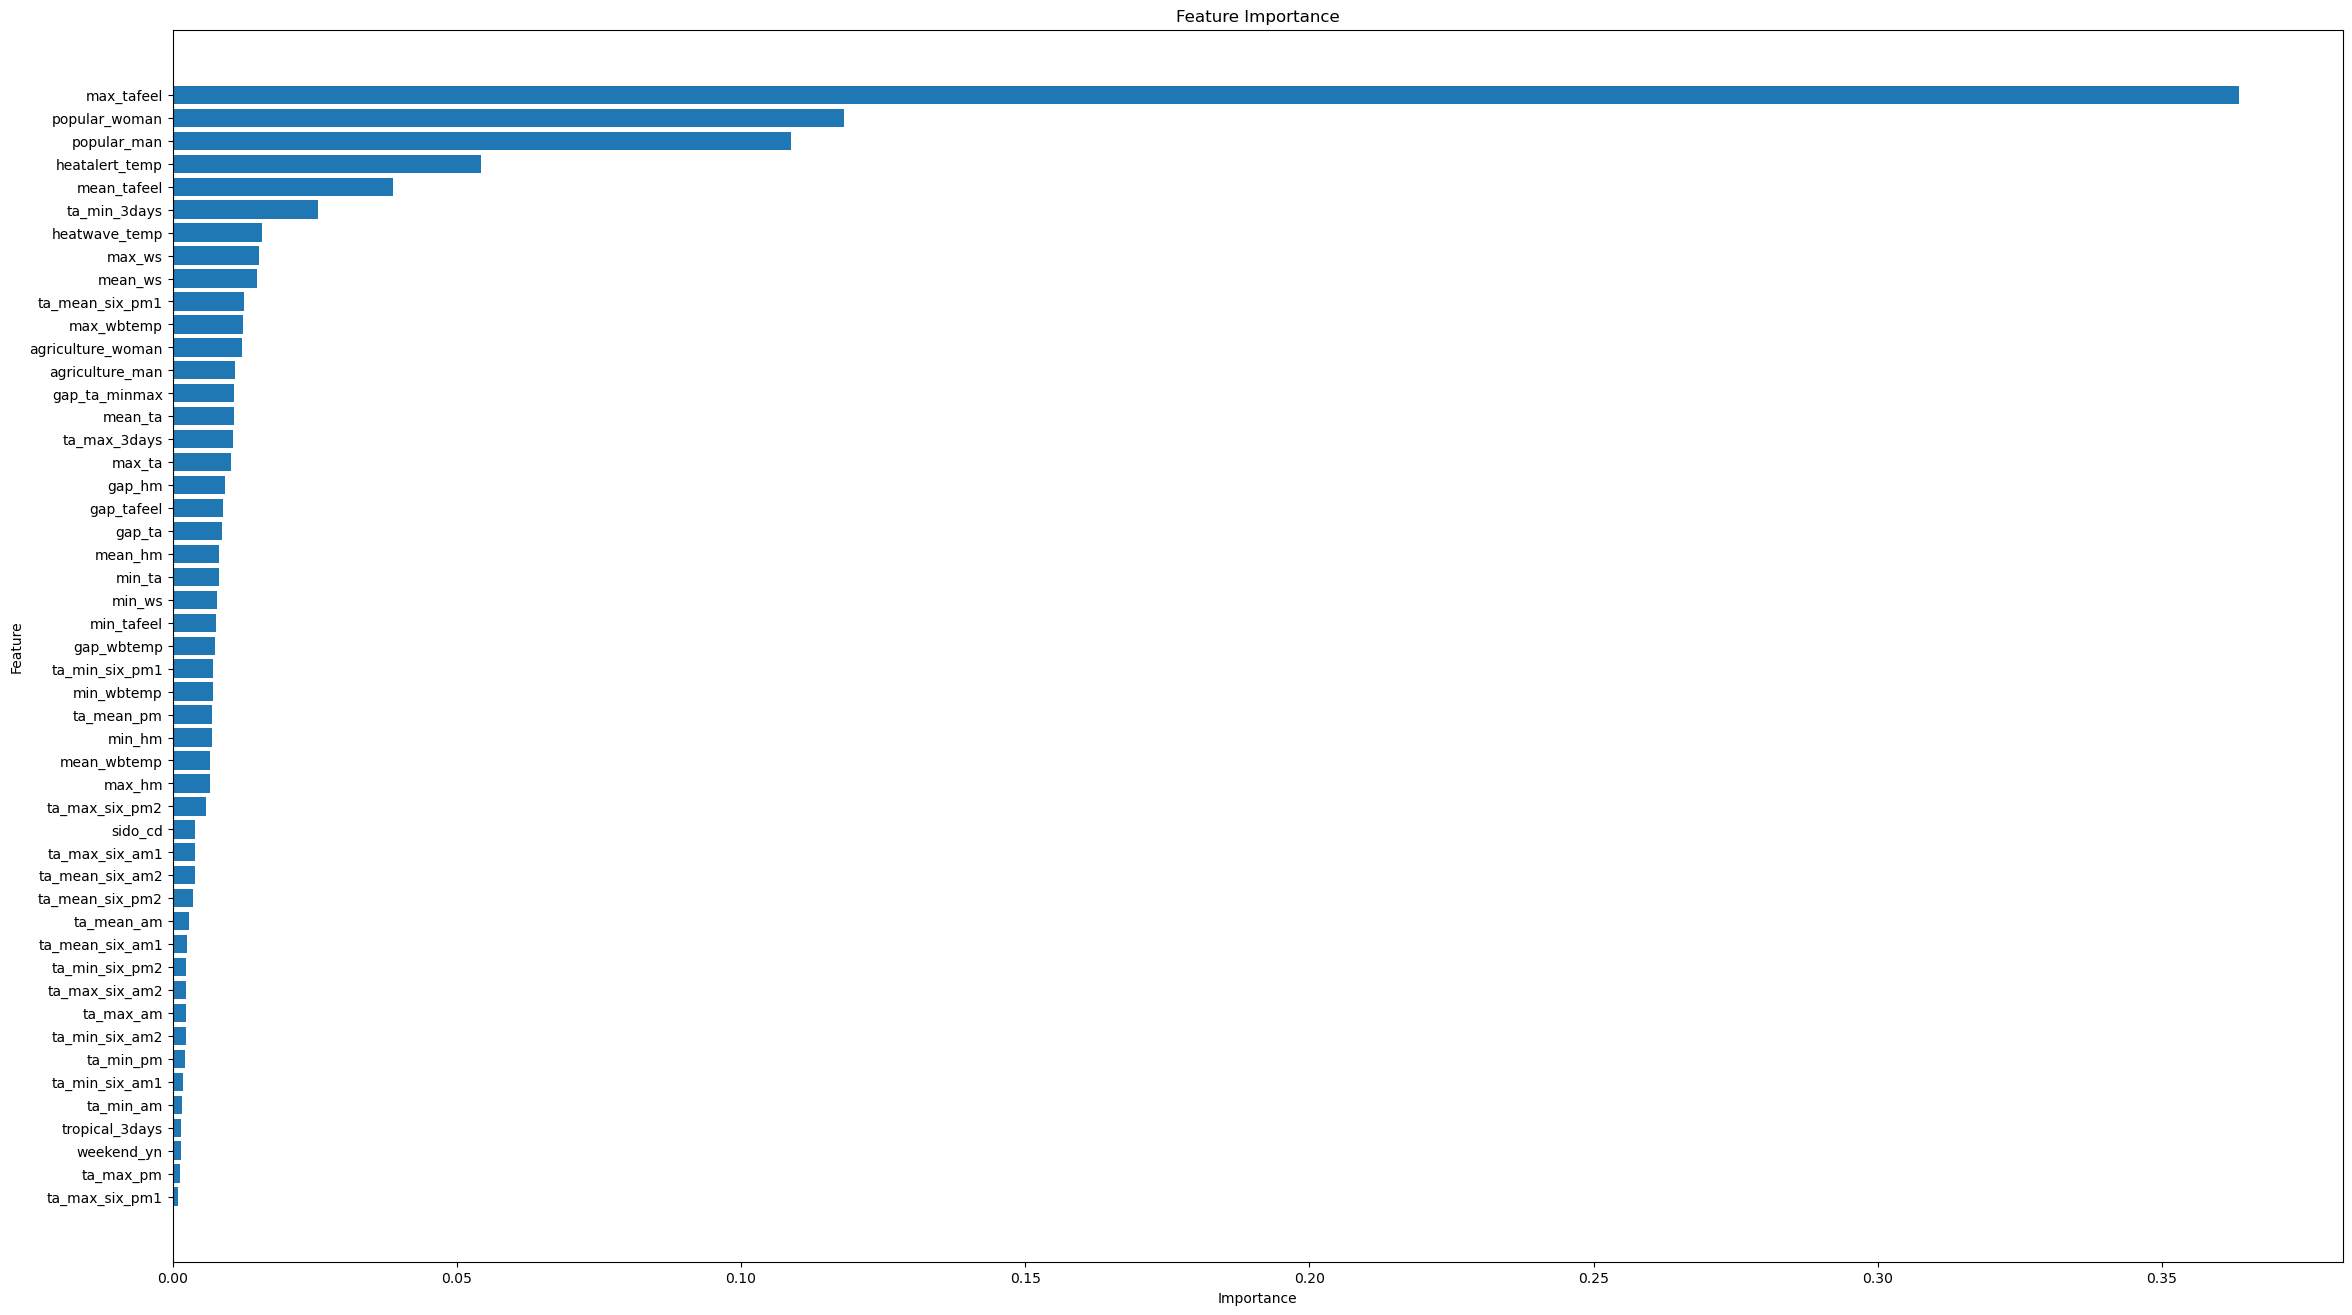

In [14]:
# 특성 중요도 시각화
plt.figure(figsize=(28, 16))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

In [10]:
# 중요도가 높은 상위 N개의 특성 선택
N = 15
top_features = importance_df['Feature'].head(N).tolist()
# 중요 특성만을 사용하여 모델 재학습
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

#### RandomForest Modeling

In [13]:
rf_model_top = RandomForestRegressor(n_estimators=100, random_state=11)
rf_model_top.fit(X_train_top, y_train)

# 예측
y_pred_train_rf_top = rf_model_top.predict(X_train_top)
y_pred_test_rf_top = rf_model_top.predict(X_test_top)

# 평가
mae_train_rf_top = mean_absolute_error(y_train, y_pred_train_rf_top)
rmse_train_rf_top = np.sqrt(mean_squared_error(y_train, y_pred_train_rf_top))
r2_train_rf_top = r2_score(y_train, y_pred_train_rf_top)

mae_test_rf_top = mean_absolute_error(y_test, y_pred_test_rf_top)
rmse_test_rf_top = np.sqrt(mean_squared_error(y_test, y_pred_test_rf_top))
r2_test_rf_top = r2_score(y_test, y_pred_test_rf_top)

print("Random Forest Regressor with Top Features:")
print(f'Training MAE: {mae_train_rf_top}')
print(f'Training RMSE: {rmse_train_rf_top}')
print(f'Training R2: {r2_train_rf_top}')
print()
print(f'Test MAE: {mae_test_rf_top}')
print(f'Test RMSE: {rmse_test_rf_top}')
print(f'Test R2: {r2_test_rf_top}')

Random Forest Regressor with Top Features:
Training MAE: 0.19544405997693196
Training RMSE: 0.4884173217648235
Training R2: 0.9565038626007711

Test MAE: 0.5185467128027681
Test RMSE: 1.1998204722813735
Test R2: 0.7626725022056844


#### XGBoost Modeling

In [14]:
xgb_model_top = XGBRegressor(n_estimators=100, learning_rate=0.1,  random_state=11)
xgb_model_top.fit(X_train_top, y_train)

# 예측
y_pred_train_xgb_top = xgb_model_top.predict(X_train_top)
y_pred_test_xgb_top = xgb_model_top.predict(X_test_top)

# 평가
mae_train_xgb_top = mean_absolute_error(y_train, y_pred_train_xgb_top)
rmse_train_xgb_top = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb_top))
r2_train_xgb_top = r2_score(y_train, y_pred_train_rf_top)

mae_test_xgb_top = mean_absolute_error(y_test, y_pred_test_xgb_top)
rmse_test_xgb_top = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb_top))
r2_test_xgb_top = r2_score(y_test, y_pred_test_xgb_top)

print("Random Forest Regressor with Top Features:")
print(f'Training MAE: {mae_train_xgb_top}')
print(f'Training RMSE: {rmse_train_xgb_top}')
print(f'Training R2: {r2_train_xgb_top}')
print()
print(f'Test MAE: {mae_test_xgb_top}')
print(f'Test RMSE: {rmse_test_xgb_top}')
print(f'Test R2: {r2_test_xgb_top}')

Random Forest Regressor with Top Features:
Training MAE: 0.3836299868767637
Training RMSE: 0.7786307795002108
Training R2: 0.9565038626007711

Test MAE: 0.503431449515499
Test RMSE: 1.1726989283269966
Test R2: 0.7732806205749512


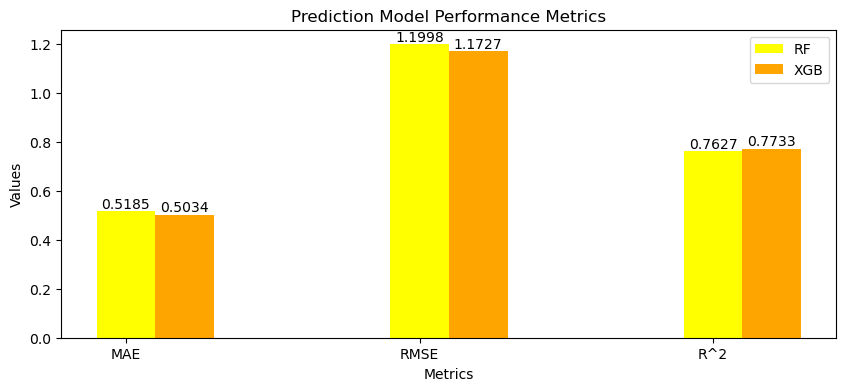

In [17]:
# 성능 평가 지표를 리스트로 정리
metrics = ['MAE', 'RMSE', 'R^2']
rf_values = [mae_test_rf_top, rmse_test_rf_top, r2_test_rf_top]
xgb_values = [mae_test_xgb_top, rmse_test_xgb_top, r2_test_xgb_top]

# 시각화
x = np.arange(len(metrics))  # 각 지표에 대한 레이블 위치
width = 0.2  # 막대 너비

fig, ax = plt.subplots(figsize=(10, 4))
bars1 = ax.bar(x + 0.0 * width, rf_values, width, label='RF', color='yellow')
bars2 = ax.bar(x + 1.0 * width, xgb_values, width, label='XGB', color='orange')

# 막대 그래프에 값 표시
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')

add_labels(bars1)
add_labels(bars2)

# 레이블 및 제목 설정
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Prediction Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# plt.savefig('Prediction Model Performance Metrics.png')
plt.show()

#### 2. Drop Column Importance

In [3]:
path='/home/hwchoi/001.project/data/T_PATIENTS_DAILY_WHOLE_0731.csv'
df=pd.read_csv(path)
df.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,...,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,...,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


In [4]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [5]:
features=['weekend_yn', 'sido_cd', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
       'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
       'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2',
       'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'
print(len(features))

49


In [6]:
# 데이터 스케일링
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=11, shuffle=True)

In [7]:
def drop_column_importance(model, X_train, y_train, X_test, y_test):
    # 모델 학습 및 기본 성능 평가
    model.fit(X_train, y_train)
    baseline_score = mean_squared_error(y_test, model.predict(X_test))
    
    importances = {}
    for col in X_train.columns:
        X_train_drop = X_train.drop(col, axis=1)
        X_test_drop = X_test.drop(col, axis=1)
        
        model.fit(X_train_drop, y_train)
        drop_score = mean_squared_error(y_test, model.predict(X_test_drop))
        importances[col] = baseline_score - drop_score
    
    return importances

In [8]:
# 모델 초기화
rf_model_drop = RandomForestRegressor(n_estimators=100, random_state=11)

# Drop Column Importance 계산
drop_importances = drop_column_importance(rf_model_drop, X_train, y_train, X_test, y_test)
drop_importances_sorted = {k: v for k, v in sorted(drop_importances.items(), key=lambda item: item[1], reverse=True)}

print("Drop Column Importance:")
print(drop_importances_sorted)

: 

#### Permitation Importance

In [ ]:
# 모델 학습
model.fit(X_train, y_train)

# Permutation Importance 계산
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

perm_importances = {name: imp for name, imp in zip(X_test.columns, perm_importance.importances_mean)}
perm_importances_sorted = {k: v for k, v in sorted(perm_importances.items(), key=lambda item: item[1], reverse=True)}

print("Permutation Importance:")
print(perm_importances_sorted)